<a href="https://colab.research.google.com/github/Visvaldis/diploma/blob/main/TensorflowResearchPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import PIL
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from datetime import datetime

%matplotlib inline
%load_ext tensorboard
from PIL import Image
from matplotlib import cm
import keras.backend as K

import sys,os
import json
import matplotlib.image as mpimg
from PIL import Image, ImageDraw

import tensorflow_hub as hub


## Env setup (gdrive mount and dataset build) 
### ***Skip, if local***

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
!dir
%cd gdrive/MyDrive/FIG/Dataset/build/auto_cracks_dataset
#%cd /content/gdrive/MyDrive/Legendari/FIG/Dataset/my_dataset
!dir 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

## Dataset info


In [ ]:
data_dir = os.path.normpath("/content/gdrive/MyDrive/FIG/Dataset/build")
data_dir

In [ ]:
(train_dataset, val_dataset, test_dataset), metadata = tfds.load(
    'auto_cracks_dataset',
    data_dir=data_dir,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)


## Helper functions and constants

In [ ]:
%cd ..
%cd ..
%cd ..
%cd Models/
!dir

In [ ]:
%mkdir prod
%cd prod


In [ ]:
IMG_SIZE = 224
num_classes = metadata.features['label'].num_classes

In [ ]:
get_label_name = metadata.features['label'].int2str
def show_imgs(ds, count = 3):
    itr = iter(ds)
    plt.figure(figsize=(10, 10))
    for i in range(count**2):
        image, label = next(itr)
        ax = plt.subplot(count, count, i + 1)
        plt.imshow(image)
        plt.title(get_label_name(label))
        plt.axis("off")


In [ ]:
def show_imgs_only_one_class(ds, class_name, count = 3):
    itr = iter(ds)
    plt.figure(figsize=(10, 10))
    for i in range(count**2):
        image, label = next(itr)
        while get_label_name(label) != class_name:
            image, label = next(itr)
            
        ax = plt.subplot(count, count, i + 1)
        plt.imshow(image)
        plt.title(str(get_label_name(label)))
        plt.axis("off")

In [ ]:
show_imgs(test_dataset)

In [ ]:
show_imgs_only_one_class(val_dataset, 'Replacement')

In [ ]:
show_imgs_only_one_class(val_dataset, 'Repair')

In [ ]:
def get_callbacks(directory):
    callbacks = [
    ModelCheckpoint(
        filepath= os.path.join(directory, 'checkpoints'),
        verbose=1, 
        save_best_only=True
    ),
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=30,
        verbose=1,
    ),
    TensorBoard(
        log_dir=os.path.join(directory, 'tensorboard_log'),
        histogram_freq=1,  # How often to log histogram visualizations
        embeddings_freq=0,  # How often to log embedding visualizations
        update_freq="epoch",
    )  # How often to write logs (default: once per epoch)

    ]
    return callbacks

In [ ]:
def train(model, train_ds, val_ds, test_ds, batch_size, epochs, add_info, show_TensorBoard = True):
    #directory = datetime.now().strftime("%Y-%m-%d %H:%M") +'_'+ model.name
    directory = model.name + '_' + add_info
    callbacks = get_callbacks(directory)
    history =  model.fit(train_ds, epochs=epochs, batch_size=batch_size,
                    validation_data=val_ds, callbacks=callbacks)
    model.save(os.path.join(directory, 'trained_model'))
    print("Model saved at path ", os.path.join(directory, 'trained_model'))
    if show_TensorBoard:
        %tensorboard --logdir {os.path.join(directory, 'tensorboard_log')}
        
    loss, acc = model.evaluate(test_ds)
    print("Test Accuracy", acc)
    print("Test Loss", loss)
    print("____________________________")
    return os.path.join(directory, 'tensorboard_log')

In [ ]:
def get_uncompile_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE , IMG_SIZE, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation= 'sigmoid'))
    return model

In [ ]:
def get_uncompile_vgg_model():
    model = models.Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding= 'same', activation= 'relu', input_shape=(IMG_SIZE , IMG_SIZE, 3)))
    model.add(Conv2D(16, kernel_size=(3,3), padding= 'same',activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

    model.add(Conv2D(32, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(32, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

    model.add(Conv2D(64, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(64, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(64, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(64, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding= 'same', activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation= 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation= 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation= 'sigmoid'))
    return model

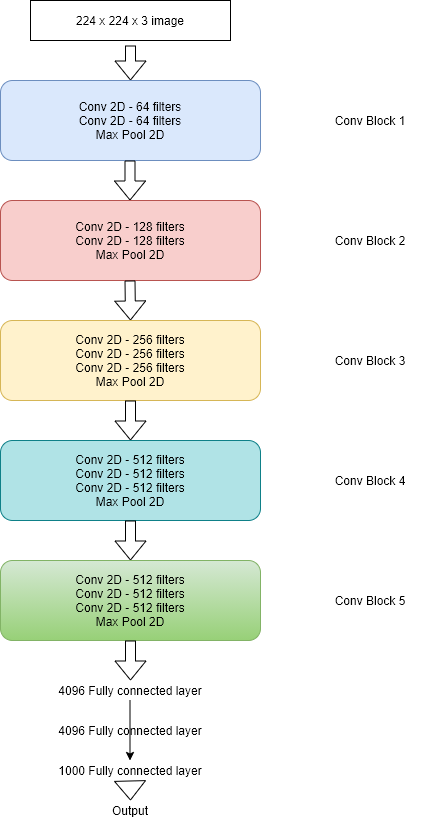

## [Image Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
#NEW_IMG_SIZE = 180

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [ ]:
def augment(image_label, seed):
    image, label = image_label
    
    image, label = resize_and_rescale(image, label)
    # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    
    #randomly_change_image_contrast
    image = tf.image.stateless_random_contrast(
        image, lower=0.3, upper=0.7, seed=new_seed)
    
    #randomly_change_image_brightness
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    
    #randomly_flip_image
    image = tf.image.stateless_random_flip_left_right(
        image, seed=new_seed)
    
    image = tf.image.stateless_random_flip_up_down(
        image, seed=new_seed)
   
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
resize_and_rescaleModel = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])


In [ ]:
def get_augmented_data(train_data, val_data, test_data, batch_size):
    counter = tf.data.experimental.Counter()
    train_ds = tf.data.Dataset.zip((train_data, (counter, counter)))
    train_ds = (
        train_ds
        .shuffle(1000)
        .map(augment, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    val_ds = (
        val_data
        .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    ) 
    test_ds = (
        test_data
        .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return train_ds, val_ds, test_ds 

def get_augmented_data_(train_data, val_data, test_data, batch_size):
  train_ds = train_data.map(lambda x, y: (resize_and_rescaleModel(x, training=True), y))
  val_ds = val_data.map(lambda x, y: (resize_and_rescaleModel(x, training=True), y))
  test_ds = test_data.map(lambda x, y: (resize_and_rescaleModel(x, training=True), y))
 
  return train_ds, val_ds, test_ds 



## Lets do it

In [ ]:
epochs_count = 60
batch_size = 64

#### My VGG augmented

In [ ]:
modelSimple = get_uncompile_vgg_model()
train_ds, val_ds, test_ds = get_augmented_data(train_data=train_dataset, 
                                               val_data=val_dataset, test_data=test_dataset, batch_size=batch_size)

modelSimple.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [ ]:

tensorboard_path = train(modelSimple, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, 
                     epochs=epochs_count,  batch_size=batch_size, add_info='my_vgg_aug' )

In [ ]:
%tensorboard --logdir {tensorboard_path}

In [ ]:
train_ds, val_ds, test_ds = get_augmented_data(train_data=train_dataset, 
                                               val_data=val_dataset, test_data=test_dataset, batch_size=batch_size)

In [ ]:
#VGG-19
model3 = tf.keras.applications.VGG19(
    include_top=True, weights=None, input_tensor=None,
    input_shape=None, pooling=None, classes=num_classes ,
    classifier_activation='sigmoid'
)
# COMPILE
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model3_path = train(model3, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, 
                     epochs=epochs_count,  batch_size=batch_size, add_info='vgg' )

In [ ]:
%tensorboard --logdir {model3_path}

## Model creating

In [ ]:
optimisers = [
    (tf.keras.optimizers.Adam, 'adam'),
    (tf.keras.optimizers.Adamax, 'adamax'),
    (tf.keras.optimizers.Adagrad, 'adagrad'),
    (tf.keras.optimizers.Adadelta, 'adadelta'),
    (tf.keras.optimizers.SGD, 'sgd'),
    (tf.keras.optimizers.Nadam, 'nadam')
    ]
learning_rates = [1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6]
batch_sizes = [256, 128, 64, 32]

In [ ]:
for optimiser, optimiser_name in optimisers:
    for learning_rate in learning_rates:
        for batch in batch_sizes:
            K.clear_session()
            model = get_uncompile_model()
            train_ds, val_ds, test_ds = get_augmented_data(train_data=train_dataset, 
                                                           val_data=val_dataset, test_data=test_dataset, batch_size=batch)

            model.compile(optimizer=optimiser(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
            add_info = optimiser_name + '_' + str(learning_rate) +'_'+str(batch)
            print(add_info)
            history = train(model, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, 
                     epochs=epochs_count,  batch_size=batch, add_info=add_info)
            

In [ ]:
def getFullPath(path):
    return os.path.join(os.getcwd(), path)

## Pretrained


In [ ]:
# ================================================= #
#                Pretrained Hub Model               #
# ================================================= #

# Random data for demonstration (3 examples w. 3 classes)
x = tf.random.normal(shape=(3, 299, 299, 3))
y = tf.constant([0, 1, 2])

url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"

base_model = hub.KerasLayer(url, input_shape=(224, 224, 3))
model = keras.Sequential(
    [
        base_model,
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

train_ds, val_ds, test_ds = get_augmented_data(train_data=train_dataset, 
                                               val_data=val_dataset, test_data=test_dataset, batch_size=32)

pr_path = train(model, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, 
                     epochs=15,  batch_size=32, add_info='pretrain' )


In [ ]:
%tensorboard --logdir {pr_path}

In [ ]:
url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"

base_model = hub.KerasLayer(url, input_shape=(224, 224, 3))
base_model.trainable = False


model = keras.Sequential(
    [
        base_model,
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax'),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
train_ds, val_ds, test_ds = get_augmented_data(train_data=train_dataset, 
                                               val_data=val_dataset, test_data=test_dataset, batch_size=64)

pr_path = train(model, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, 
                     epochs=256,  batch_size=64, add_info='pretrainNonFreeze' )

In [ ]:
%tensorboard --logdir {pr_path}

In [ ]:
print(tf.__version__)

In [ ]:
def crop_polygon(img, polygon):
    maskIm = Image.new('L', (img.shape[1], img.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask = np.array(maskIm)

    # assemble new image (uint8: 0-255)
    newImArray = np.empty(img.shape,dtype='uint8')

    # colors (three first columns, RGB)
    newImArray[:,:,:3] = img[:,:,:3]

    # transparency (4th column)
    newImArray[:,:,3] = mask*255
    return newImArray

In [ ]:
def crop_box(img, xmin, ymin, xmax, ymax):
    crop_img = img[ymin:ymax, xmin:xmax]
    return crop_img

In [ ]:
def load_image(path):
    img = mpimg.imread(path)
    
    if img.shape[2] == 3:
        newImArray = np.empty(
            (img.shape[0],img.shape[1],img.shape[2]+1),
            dtype='uint8')
        newImArray[:,:,:3] = img[:,:,:]
        newImArray[:,:,3] = 255
        result = newImArray
    else:
         result = img
            
    return result


def show_image(img):
    imgplot = plt.imshow(img)
    plt.show()

def show_images_side_by_side(img1, img2):
    _, axarr = plt.subplots(1,2)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()

In [ ]:
def prepare_urls(path):
    for root, dirs, files in os.walk(path):
        for filename in files:
            pol_path = os.path.join(root, filename)
            with open(pol_path,'r') as jsonFile:
                data = json.load(jsonFile) 
            data['path'] = make_url_relative(data['path'])
            with open(pol_path,'w') as jsonFile:
                json.dump(data, jsonFile)


def make_url_relative(url):
    return url[url.index('train'):]


def get_categories(labels_path): 
    categories = {}
    for root, dirs, files in os.walk(labels_path):
        for filename in files:
            file = open(os.path.join(root, filename),)
            data = json.load(file)
            data = data['outputs']
            if data == {}:
                print(os.path.join(root, filename))
                category_set = {"NO_CATEGORY"}
            else:
                category_set = set([x['name'] for x in data['object']])
            for current in category_set:
                if current in categories:
                    categories[current] = categories[current]+ 1 
                else:
                    categories[current] = 1
    sorted_cat= sorted(categories.items(), key=lambda x: x[1], reverse=True)
    return sorted_cat


def get_categories_with_images(dataset_path): 
    labels_path = os.path.join(dataset_path, 'labels')
    categories = {}
    for root, dirs, files in os.walk(labels_path):
        for filename in files:
            file = open(os.path.join(root, filename),)
            data = json.load(file)
            outputs = data['outputs']
            if outputs == {}:
                category_set = {"NO_CATEGORY"}
            else:
                category_set = set([x['name'] for x in outputs['object']])
            for current in category_set:
                if current in categories:
                    categories[current] = categories[current]+ 1 
                else:
                    categories[current] = 1
                    print(current)
                    show_image(load_image(os.path.join(dataset_path,data['path'])))
                    
    sorted_cat= sorted(categories.items(), key=lambda x: x[1], reverse=True)
    return sorted_cat

In [ ]:
def process_file_image(label_path):
    jsonFile = open(label_path,)
    pdata = json.load(jsonFile)
    image_path = os.path.join(os.getcwd(), pdata['path'])
    img = load_image(image_path)
    show_image(img)
    pdata = pdata['outputs']['object']
    for obj in pdata:
        print(obj)
        if 'polygon' in obj:
            polygon_data = obj['polygon']
            i = 1
            res = []
            while 'x'+str(i) in polygon_data:
                res.append((polygon_data['x'+str(i)], polygon_data['y'+str(i)]))
                i += 1
            cropped = crop_polygon(img, res)

        elif 'bndbox' in obj:
            box_data = obj['bndbox']
            cropped = crop_box(img,box_data['xmin'], box_data['ymin'], box_data['xmax'], box_data['ymax'])
        
        show_image(cropped)


In [ ]:
def process_file_bound(label_path):
    jsonFile = open(label_path,)
    pdata = json.load(jsonFile)
    image_path = os.path.join(os.getcwd(), pdata['path'])
    img = load_image(image_path)
    show_image(img)
    
    pdata = pdata['outputs']['object']
    for obj in pdata:
        print(obj)
        if 'polygon' in obj:
            polygon_data = obj['polygon']
            i = 1
            polygon_coordinates = []
            while 'x'+str(i) in polygon_data:
                polygon_coordinates.append((polygon_data['x'+str(i)], polygon_data['y'+str(i)]))
                i += 1
                
            xmin = round(min(polygon_coordinates, key = lambda t: t[0])[0])
            xmax = round(max(polygon_coordinates, key = lambda t: t[0])[0])
            ymin = round(min(polygon_coordinates, key = lambda t: t[1])[1])
            ymax = round(max(polygon_coordinates, key = lambda t: t[1])[1])
            print("xmin", xmin)
            print("xmax", xmax)
            print("ymin", ymin)
            print("ymax", ymax)  

            croppedPolygon = crop_polygon(img, polygon_coordinates)
            croppedBox = crop_box(img, xmin, ymin, xmax, ymax)
        
        elif 'bndbox' in obj:
            box_data = obj['bndbox']
            xmin =  box_data['xmin']
            xmax =  box_data['xmax']
            ymin = box_data['ymin']
            ymax = box_data['ymax']
            
            polygon_coordinates = [(xmin, ymin), (xmin, ymax), (xmax,ymax), (xmax, ymin)]
            croppedPolygon = crop_polygon(img, polygon_coordinates)
            croppedBox = crop_box(img, xmin, ymin, xmax, ymax)
        
        print("Polygon")
        show_image(croppedPolygon)
        print("Box")
        show_image(croppedBox)
        

In [ ]:
lbox = r'C:\Users\VsevolodSlavinskyi\Desktop\Data\Diploma\Project\Data\new_data\labels\repair\20190102--200419_SR5_94a2febe-b7d0-408c-9fad-b8c460edf2f5_398D3840-8778-49BF-8B82-45A6073944E2.json'
lpolygon = r'C:\Users\VsevolodSlavinskyi\Desktop\Data\Diploma\Project\Data\new_data\labels\replacement\20190502--191849_Orlando Tech_f3f76d40-80d9-4324-87fc-305c89d2e9b8_7709FF88-EECE-40E7-B64B-8D256FB9D0DA.json'
process_file_new(lbox)
process_file_new(lpolygon)


In [ ]:
labels_path = r'C:\Users\VsevolodSlavinskyi\Desktop\Data\Diploma\Project\Data\auto_cracks_dataset\auto_cracks\labels'
dataset_path =  r'C:\Users\VsevolodSlavinskyi\Desktop\Data\Diploma\Project\Data\auto_cracks_dataset\auto_cracks'

In [ ]:
cats = get_categories_with_images(dataset_path)


In [ ]:
cats

In [ ]:
old_data_path = r'C:\Users\VsevolodSlavinskyi\Desktop\Data\Diploma\FIG-Recognition-Engine\my_dataset\batch_data_full_224'

In [ ]:
 with open(os.path.join(old_data_path, 'dataset_metadata.json'),'r') as jsonFile:
    data = json.load(jsonFile) 
    print(len(data), type(data))
    non_empty_data = [x for x in data if x['coordinates']['height'] != 0]
    print(len(non_empty_data), type(non_empty_data))

In [ ]:
item = non_empty_data[0]
item

In [ ]:
for item in non_empty_data[::10]:
    print(item['label'])
    img = load_image(os.path.join(old_data_path,'train',item['fileName']))
    coord = item['coordinates']
    croppedBox = crop_box(img,round(coord['x']),round(coord['y']),round(coord['x']) + coord['width'],round(coord['y']) + coord['height'])

    show_images_side_by_side(img,croppedBox)
    print('_____________________________')